# <span style="color:#0073e6">0. 사례준비</span>

> **Libaray & Environment Settings** 

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
np.random.seed(123)

> **MNIST DATA SET LOADING**

In [2]:
with open('data/mnist.pkl', 'rb') as f:
    _, _, t = pickle.load(f, encoding='latin1')
x, y = t[0], t[1]
del t
print(x.shape)
print(y.shape)

(10000, 784)
(10000,)


> **이미지로 원본 데이터 확인**

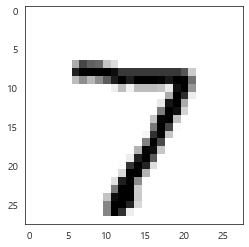

In [3]:
digit = x[0].reshape(28,28)
plt.imshow(digit, cmap=plt.cm.binary);

- - -
# <span style="color:#0073e6">1. PCA<span>

### 1.2. Basic PCA

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=x.shape[1], whiten=False)
pca.fit(x)
x_pca = pca.transform(x)

> **주성분에 의해 설명되는 분산비율**

In [5]:
sum(pca.explained_variance_ratio_)

0.9999999553585497

In [6]:
comp = [10, 20, 50, 100, 200]
for c in comp:
    v = sum(pca.explained_variance_ratio_[:c])
    print('%3d개 주성분 : %.4f' % (c, v))

 10개 주성분 : 0.4971
 20개 주성분 : 0.6533
 50개 주성분 : 0.8316
100개 주성분 : 0.9184
200개 주성분 : 0.9683


- - -
> **결과 시각화**
>> 시각화 함수 정의

In [7]:
def scatter(x, y, p='Paired'):
    gDF = pd.DataFrame(x, columns=['첫번째벡터','두번째벡터'])
    gDF['Label'] = y
    return sns.scatterplot(x='첫번째벡터',y='두번째벡터', hue='Label', 
                           palette=sns.color_palette(p, 10), data=gDF);

>> 숫자 분류에 영향을 주는 두 특성으로 산점도 시각화 (PCA 적용전)

In [8]:
RFC = RandomForestClassifier(max_depth=10, n_jobs=-1)
RFC.fit(x, y)
pca_xy = np.where((-RFC.feature_importances_).argsort()<=1)[0]
pca_xy

array([633, 687], dtype=int64)

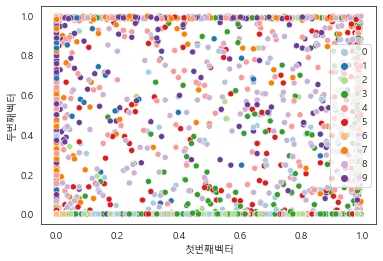

In [9]:
scatter(x[:,pca_xy],y)
plt.legend(loc='right');

>> 숫자 분류에 영향을 주는 두 특성으로 산점도 시각화 (PCA 적용 결과)

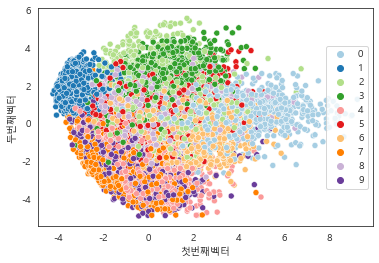

In [10]:
RFC = RandomForestClassifier(max_depth=10, n_jobs=-1)
RFC.fit(x_pca, y)
xy = np.where((-RFC.feature_importances_).argsort()<=1)[0]
scatter(x_pca[:,xy],y)
plt.legend(loc='right');

### 1.3. Incremental PCA (점진적 PCA)

In [11]:
from sklearn.decomposition import IncrementalPCA
iPCA = IncrementalPCA(n_components=x.shape[1], batch_size=None)
x_iPCA = iPCA.fit_transform(x)

> **결과 시각화**
>> 시각화 함수의 수정 : 여러 축에 그릴 수 있도록 축 정보 추가 & 주요 두성분 추출 후 시각화

In [12]:
def scatter01(x, y, axs, p='Paired', loc=0):
    gDF = pd.DataFrame(x, columns=['첫번째벡터','두번째벡터'])
    gDF['Label'] = y
    return sns.scatterplot(x='첫번째벡터',y='두번째벡터', hue='Label', 
                           palette=sns.color_palette(p, 10), data=gDF, ax=axs[loc]);
    
def RF_xy(x, y):
    RFC = RandomForestClassifier(max_depth=10, n_jobs=-1)
    RFC.fit(x, y)
    xy = np.where((-RFC.feature_importances_).argsort()<=1)[0]
    return xy

>> 시각화 결과

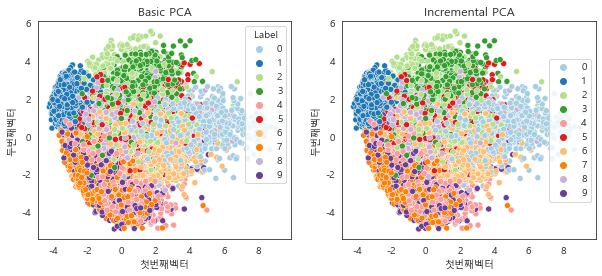

In [13]:
iPCA_xy = RF_xy(x_iPCA, y)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
scatter01(x_pca[:,xy],y, ax, loc=0)
scatter01(x_iPCA[:,iPCA_xy], y, ax, loc=1)
ax[0].set_title('Basic PCA')
ax[1].set_title('Incremental PCA')
plt.legend(loc='right');

### 1.4. Sparse PCA (희소 PCA)

In [14]:
from sklearn.decomposition import SparsePCA
sPCA = SparsePCA(n_components=x.shape[1], alpha=0.01, n_jobs=-1)
x_sPCA = sPCA.fit_transform(x)

> **결과 시각화**

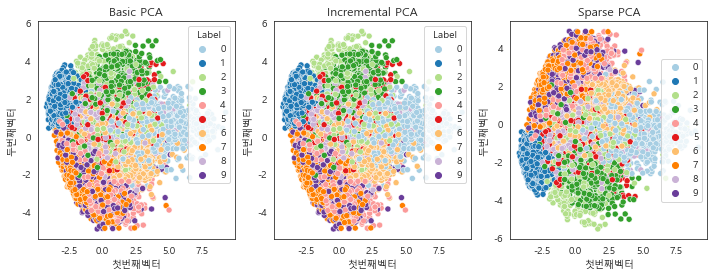

In [15]:
sPCA_xy = RF_xy(x_sPCA, y)

fig, ax = plt.subplots(ncols=3, figsize=(12,4))
scatter01(x_pca[:,xy],y, ax, loc=0)
scatter01(x_iPCA[:,iPCA_xy], y, ax, loc=1)
scatter01(x_sPCA[:,sPCA_xy], y, ax, loc=2)
ax[0].set_title('Basic PCA')
ax[1].set_title('Incremental PCA')
ax[2].set_title('Sparse PCA')
plt.legend(loc='right');

### 1.5. Kernel PCA (커널 PCA)

In [16]:
from sklearn.decomposition import KernelPCA
kPCA = KernelPCA(n_components=None, kernel='rbf', gamma=None, n_jobs=-1)
x_kPCA = kPCA.fit_transform(x)

> **결과 시각화**

In [17]:
def scatter02(x, y, axs, p='Paired', row=0, col=0):
    gDF = pd.DataFrame(x, columns=['첫번째벡터','두번째벡터'])
    gDF['Label'] = y
    return sns.scatterplot(x='첫번째벡터',y='두번째벡터', hue='Label', 
                           palette=sns.color_palette(p, 10), data=gDF, ax=axs[row,col]);

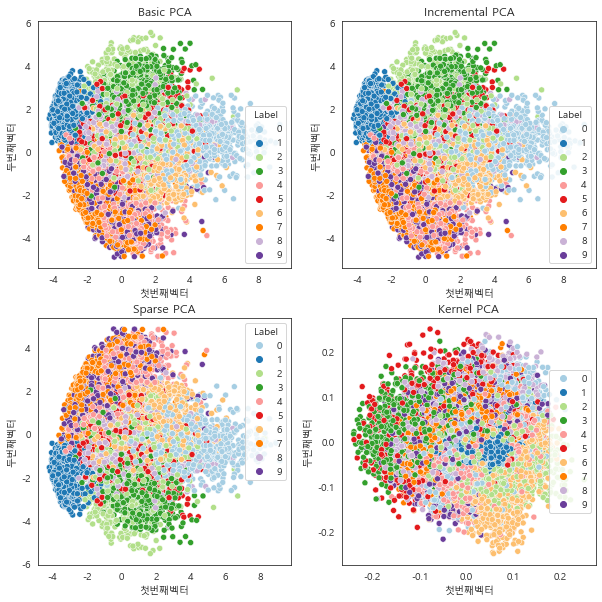

In [18]:
kPCA_xy = RF_xy(x_kPCA, y)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
scatter02(x_pca[:,xy],y, ax, row=0, col=0)
scatter02(x_iPCA[:,iPCA_xy], y, ax, row=0, col=1)
scatter02(x_sPCA[:,sPCA_xy], y, ax, row=1, col=0)
scatter02(x_kPCA[:,kPCA_xy], y, ax, row=1, col=1)
ax[0,0].set_title('Basic PCA')
ax[0,1].set_title('Incremental PCA')
ax[1,0].set_title('Sparse PCA')
ax[1,1].set_title('Kernel PCA')
plt.legend(loc='right');

- - -
# <span style="color:#0073e6">2. SVD</span>

> **SVD(Singular Value Decomposition) : 특이값 분해** 

In [19]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=78)
x_SVD = svd.fit_transform(x)

> **결과 시각화**

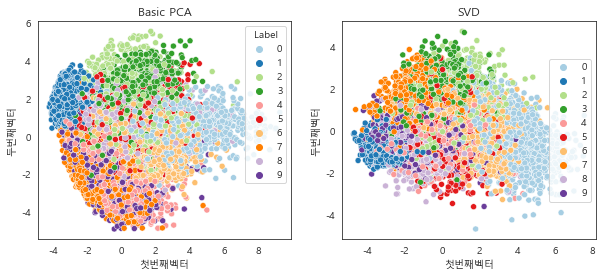

In [20]:
SVD_xy = RF_xy(x_SVD, y)

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
scatter01(x_pca[:,xy],y, ax, loc=0)
scatter01(x_SVD[:,SVD_xy], y, ax, loc=1)
ax[0].set_title('Basic PCA')
ax[1].set_title('SVD')
plt.legend(loc='right');

> **점 사이 거리의 배열이 유지되도록 저차원으로 점을 투영** 

> **GRP**

In [21]:
from sklearn.random_projection import GaussianRandomProjection
GRP = GaussianRandomProjection(n_components='auto', eps=0.5)
x_GRP = GRP.fit_transform(x)

> **SRP**

In [22]:
from sklearn.random_projection import SparseRandomProjection
SRP = SparseRandomProjection(n_components='auto', density='auto', eps=0.5)
x_SRP = SRP.fit_transform(x)

> **결과 시각화**

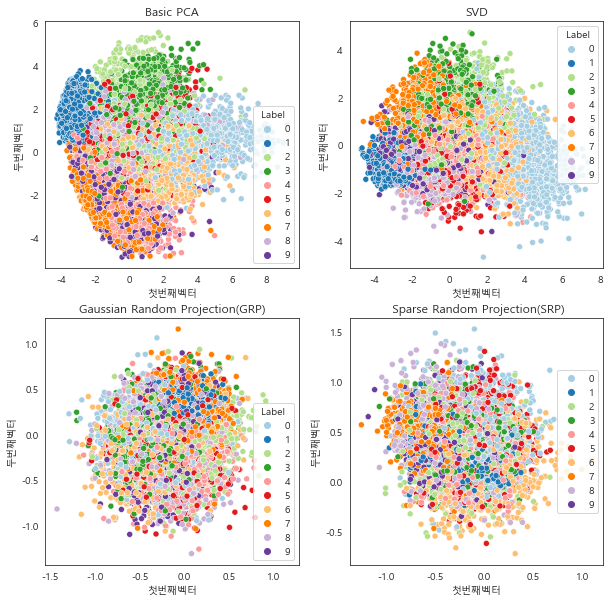

In [23]:
GRP_xy = RF_xy(x_GRP, y)
SRP_xy = RF_xy(x_SRP, y)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
scatter02(x_pca[:,xy],y, ax, row=0, col=0)
scatter02(x_SVD[:,SVD_xy], y, ax, row=0, col=1)
scatter02(x_GRP[:,GRP_xy],y, ax, row=1, col=0)
scatter02(x_SRP[:,SRP_xy], y, ax, row=1, col=1)

ax[0,0].set_title('Basic PCA')
ax[0,1].set_title('SVD')
ax[1,0].set_title('Gaussian Random Projection(GRP)')
ax[1,1].set_title(' Sparse Random Projection(SRP)')
plt.legend(loc='right');

> **Isomap**

In [24]:
from sklearn.manifold import Isomap
isomap = Isomap(n_neighbors=5, n_components=10, n_jobs=-1)
isomap.fit(x)
x_iso = isomap.transform(x)

> **t-SNE**

In [25]:
from sklearn.manifold import TSNE
tSNE = TSNE(n_components=2, learning_rate=300)
x_tSNE = tSNE.fit_transform(x_SVD)

> **ICA(Independent Component Analysis)**

In [26]:
from sklearn.decomposition import FastICA
ICA = FastICA(n_components=25, whiten=True)
x_ICA = ICA.fit_transform(x)

> **결과 시각화**
>> tSNE시각화

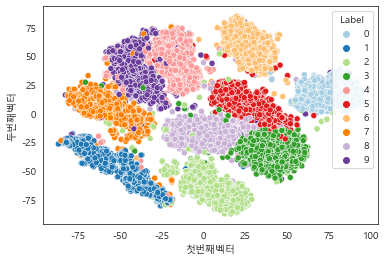

In [27]:
g = pd.DataFrame(x_tSNE, columns=['첫번째벡터','두번째벡터'])
g['Label'] = y
sns.scatterplot(x='첫번째벡터',y='두번째벡터', hue='Label',
                palette=sns.color_palette('Paired', 10), data=g);

>> 비선형 차원축소 시각화

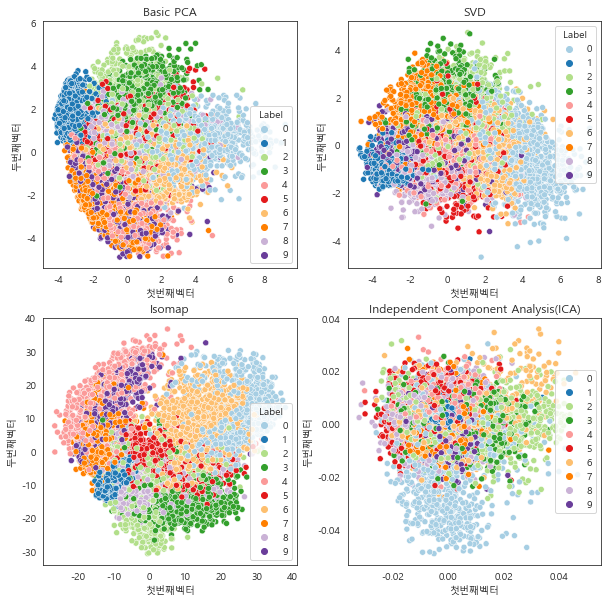

In [28]:
ISO_xy = RF_xy(x_iso, y)
ICA_xy = RF_xy(x_ICA, y)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
scatter02(x_pca[:,xy],y, ax, row=0, col=0)
scatter02(x_SVD[:,SVD_xy], y, ax, row=0, col=1)
scatter02(x_iso[:,ISO_xy],y, ax, row=1, col=0)
scatter02(x_ICA[:,ICA_xy], y, ax, row=1, col=1)

ax[0,0].set_title('Basic PCA')
ax[0,1].set_title('SVD')
ax[1,0].set_title('Isomap')
ax[1,1].set_title('Independent Component Analysis(ICA)')
plt.legend(loc='right');